In [1]:
# test_imports in this cell, restart kernel whenever edits to modules are made

import sys
import os
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

#import config based on which machine the jupyter notebook is running on
from configs.config_local import *
from preprocessing import *
from module_detection import *
from utils import *

def test_imports():
    print("testing config class")
    config = Config()
    print(config)
    print("testing preprocessing")
    query = HiCQuery(config, config.param_lists.chromosomes[0], config.current_res, config.current_res_str)
    print(query)
    print("testing module_detection")
    graph = HiCGraph(config, config.param_lists.chromosomes[0], config.current_res, config.current_res_str, config.nodeset_key)
    print(graph)

test_imports()

testing config class
testing preprocessing
HiC file loaded
testing module_detection


## using OE as graph edges 

In [2]:
## QUERIED OE MAP ##

config = Config()
chrom = config.param_lists.chromosomes[0]
current_res = config.current_res 
current_res_str = config.current_res_str  
query = HiCQuery(config, chrom, current_res, current_res_str) #create query object
# params for OE matrix visualisation
noise_threshold = config.noise_threshold
start = config.start
end = config.end
# Custom colormap
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1, 1, 1), (1, 0, 0)])
## single chr visualisation  objects ##
oe_query = query.records_as_csr('oe',noise_threshold) 
oe_query_numpy = oe_query.toarray() #load dense matrix of a region for visualisation
region_str = format_loci_string(start, end, '1Mb') 

HiC file loaded


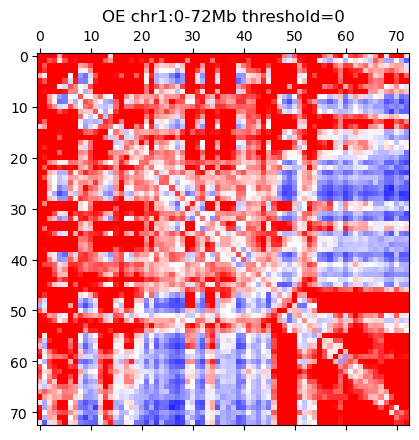

In [3]:
def plot_single_hic_map(dense_matrix, cmap, vmin=0, vmax=30, title=""):
    d2 = dense_matrix
    d2[np.isnan(d2)] = 0
    d2[np.isinf(d2)] = 0
    plt.matshow(dense_matrix, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.show()

plot_single_hic_map(oe_query_numpy, 'bwr', 0, 1, f"O/E weights {chrom}; noise_threshold={noise_threshold}; resolution={current_res_str}")

In [4]:
## GRAPH INPUT ADJACENCY MAP ##

oe_graph = HiCGraph(config, chrom, current_res, current_res_str, config.nodeset_key) #create graph object
oe_graph.load_edges()  

In [ ]:
# apply distance thresholding filter (run any number of times to move forward if running continuously)
start_filter_at = 2*config.long_range_min_distance
oe_graph.apply_genomic_distance_filter(start_filter_at) #min_dist vs stride type
oe_graph.edgelist_to_csr_affinity_matrix()

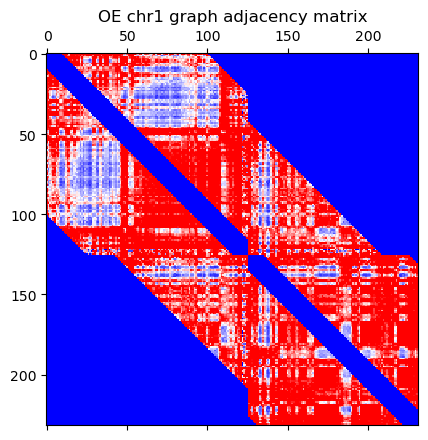

In [5]:
oe_graph_affinity = oe_graph.affinity_matrix #load prepared affinity matrix
oe_graph_numpy = oe_graph_affinity.toarray() #convert to dense matrix for visualisation
plot_single_hic_map(oe_graph_numpy, 'bwr', 0, 1, f"OE {chrom} graph adjacency matrix, noise_threshold = {noise_threshold}")

In [6]:
# save adj matrix in neo4j file format for graph viz
#oe_graph.save_thresholded_graph_to_neo4j_csv()
oe_graph.save_graph_as_gexf()

Nodes CSV saved to /Users/Akanksha/MaGroup/Genomic-Hubs/workflow/tmp/GM12878/affinity_matrices/OE_1Mb_affinity/chr1_nodes.csv
Edges CSV saved to /Users/Akanksha/MaGroup/Genomic-Hubs/workflow/tmp/GM12878/affinity_matrices/OE_1Mb_affinity/chr1_edges.csv


## Cluster performance accuracy and metrics for 2 way clustering with ground truth A/B compartments

HiC file loaded


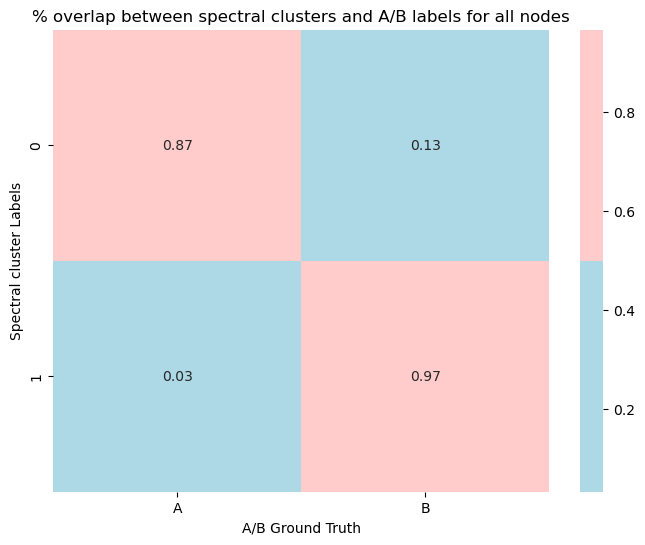

(0.9666666666666667, 0.8854961832061069, 0.9243027888446215)


In [3]:
## plot confusion matrix between cluster labels and ab scores ##
##### DEBUG : the conf matrix varies on each execution, need to fix this #####
from matplotlib.colors import ListedColormap

def plot_confusion_matrix_heatmap(confusion_matrix):
    """
    Plot the confusion matrix as a heatmap.

    Parameters:
    confusion_matrix (numpy.ndarray): A 2x2 confusion matrix.
    """
    cnf_mtx_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    gt_labels = ['A', 'B']
    cluster_labels = ['0', '1']
    colors = ['#add8e6', '#ffcccb']  # light red and blue
    cmap = ListedColormap(colors)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cnf_mtx_norm, annot=True, fmt='.2f', cmap=cmap, xticklabels=gt_labels, yticklabels=cluster_labels)
    plt.xlabel('A/B Ground Truth')
    plt.ylabel('Spectral cluster Labels')
    plt.title('% overlap between spectral clusters and A/B labels for all nodes')
    plt.show()

config = Config()
nodeset_key = config.nodeset_key
conf_matx, accuracy_metrics = run_single_chrom_eval("chr1", config, 1000000, "1Mb", nodeset_key)
plot_confusion_matrix_heatmap(conf_matx)
print(accuracy_metrics) #precion, recall, f1 score
#F1 is better as not all chromosomes have equal number of A/B compartments

    chrom  precision    recall        f1
0    chr1   0.965812  0.862595  0.911290
1    chr2   0.186441  0.162963  0.173913
2    chr3   0.101124  0.079646  0.089109
3    chr4   0.657895  0.200000  0.306748
4    chr5   0.957447  0.420561  0.584416
5    chr6   0.978947  0.939394  0.958763
6    chr7   0.716418  0.905660  0.800000
7    chr8   1.000000  0.260000  0.412698
8    chr9   0.888889  0.096386  0.173913
9   chr10   0.355263  0.317647  0.335404
10  chr11   0.949367  0.842697  0.892857
11  chr12   0.941176  0.200000  0.329897
12  chr13   1.000000  0.030769  0.059701
13  chr14   0.967742  0.566038  0.714286
14  chr15   0.372881  0.458333  0.411215
15  chr16   1.000000  0.490566  0.658228
16  chr17   1.000000  0.418605  0.590164
17  chr18   1.000000  0.098039  0.178571
18  chr19   0.931034  0.931034  0.931034
19  chr20   1.000000  0.700000  0.823529
20  chr21   0.500000  0.068966  0.121212
21  chr22   0.482759  0.583333  0.528302
22   chrX   0.784314  0.434783  0.559441
23   chrY   1.00

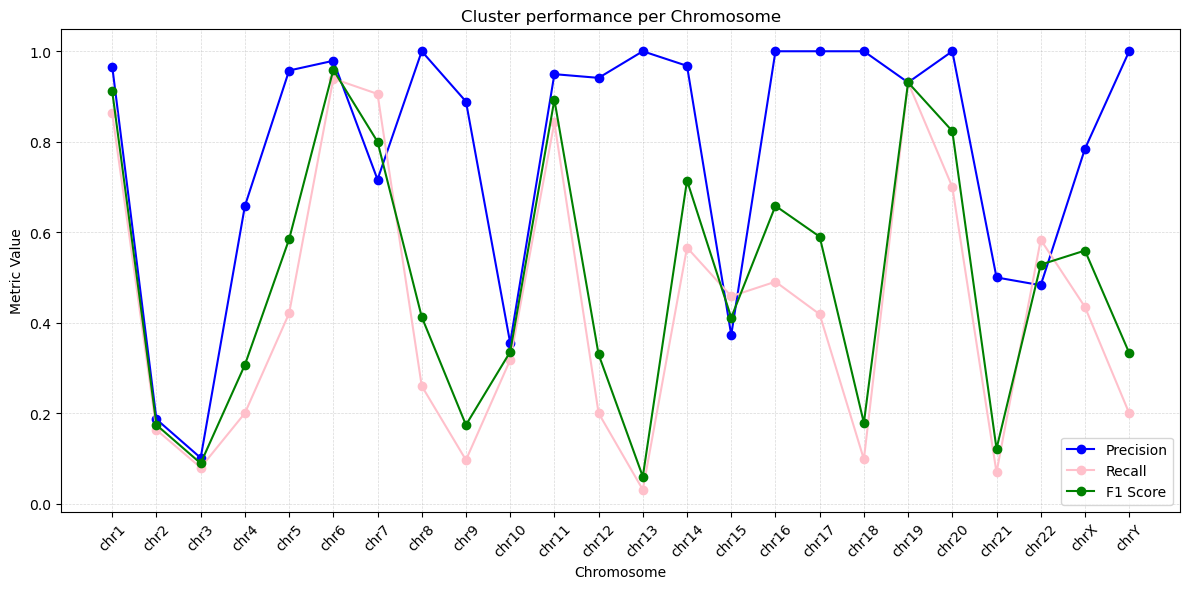

In [5]:
## whole genome accuracy metrics plot ##
metrics_file = os.path.join(config.paths.temp_dir, f"accuracy_metrics_{config.affinity_key}.csv")
metrics_df = pd.read_csv(metrics_file)
print(metrics_df)

# Plot the precision and recall per chromosome
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['chrom'], metrics_df['precision'], marker='o', label='Precision', color='blue')
plt.plot(metrics_df['chrom'], metrics_df['recall'], marker='o', label='Recall', color='pink')
plt.plot(metrics_df['chrom'], metrics_df['f1'], marker='o', label='F1 Score', color='green')
plt.xlabel('Chromosome')
plt.ylabel('Metric Value')
plt.title('Clustering performance per Chromosome')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cluster optimality plots (eigenvectors for stability and NormCut scores)

## Cluster size plots

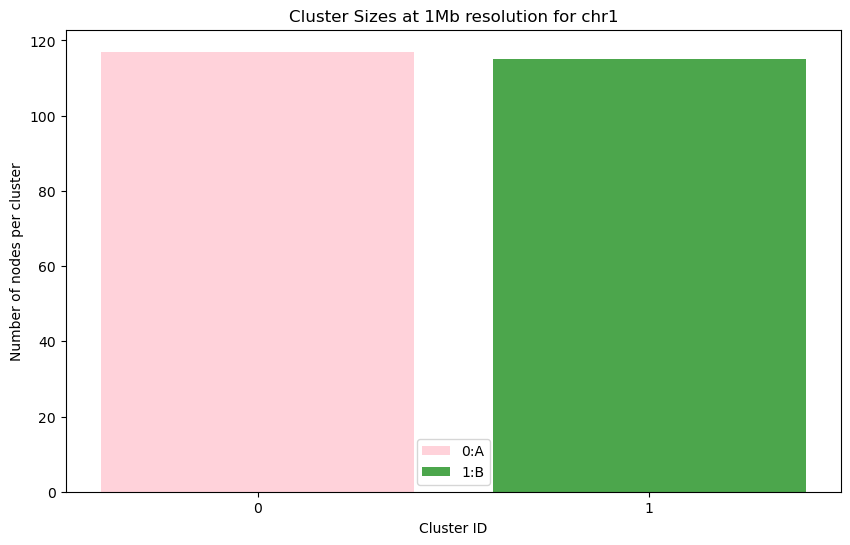

array([117, 115])

In [15]:
def cluster_size_distribution_single_chr(node_attrs_dict, chrom):
    """
    calculate cluster size distribution split between number of clusters; x = cluster_num, y = size
    input: nodeset dict {start: (set_idx, cluster_label)}
    """
    cluster_labels = [attr[1] for attr in node_attrs_dict.values()]
    # Count the number of nodes in each cluster
    cluster_sizes = np.bincount(cluster_labels)
    cluster_ids = np.arange(len(cluster_sizes))
    
    # Plot the cluster size distribution
    colors = ['pink', 'green']
    plt.figure(figsize=(10, 6))
    bars = plt.bar(cluster_ids, cluster_sizes, color=colors, alpha=0.7)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of nodes per cluster')
    plt.title(f'Cluster Sizes at 1Mb resolution for {chrom}')
    plt.legend(bars, ['0:A', '1:B'])
    plt.xticks(ticks=[0, 1], labels=['0', '1'])
    plt.show()

    return cluster_sizes

#read nodeset_attrs from pkl file
chrom = "chr1"
node_attrs_dir = os.path.join(config.paths.temp_dir, f"affinity_matrices/{config.affinity_key}")
node_attrs_dict = pd.read_pickle(f"{node_attrs_dir}/{chrom}_nodeset_attrs.pkl") 
cluster_size_distribution_single_chr(node_attrs_dict, chrom)

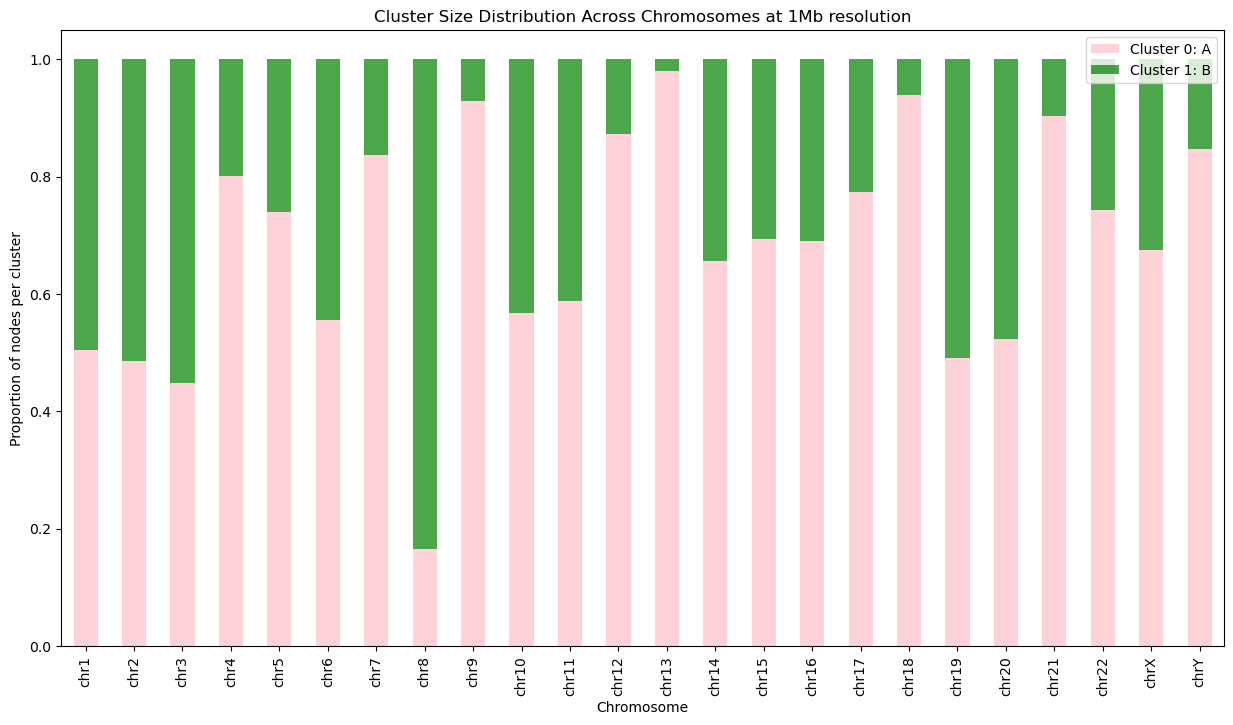

In [13]:
## WHOLE GENOME CLUSTER SIZE PLOT ##
#get whole genome nodeset_attrs using for loop
##plot the cluster size distribution for whole genome

def cluster_size_distribution_whole_genome(chromosomes, node_attrs_dir):
    """
    Calculate cluster size distribution for the whole genome.
    Each bar represents a chromosome, split into proportions of clusters 0 and 1.
    Input: chrom_list (list of chromosome names), node_attrs_dir (directory containing nodeset_attrs.pkl files).
    """
    cluster_sizes = {}
    
    for chrom in chromosomes:
        # Load nodeset_attrs for the current chromosome
        nodeset_attrs_path = os.path.join(node_attrs_dir, f"{chrom}_nodeset_attrs.pkl")
        node_attrs_dict = pd.read_pickle(nodeset_attrs_path)
        
        # Extract cluster labels and count the number of nodes in each cluster
        cluster_labels = [attr[1] for attr in node_attrs_dict.values()]
        cluster_sizes[chrom] = np.bincount(cluster_labels)
    
    # Convert cluster sizes to a DataFrame for easier manipulation
    cluster_sizes_df = pd.DataFrame(cluster_sizes).T.fillna(0)
    cluster_sizes_df.columns = ['Cluster 0', 'Cluster 1']
    
    # Calculate proportions
    total_sizes = cluster_sizes_df.sum(axis=1)
    cluster_proportions = cluster_sizes_df.divide(total_sizes, axis=0)
    
    # Plot the stacked bar plot
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Define colors for each cluster
    colors = ['pink', 'green']
    
    # Create stacked bar plot
    cluster_proportions.plot(kind='bar', stacked=True, color=colors, alpha=0.7, ax=ax)
    
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('Proportion of nodes per cluster')
    ax.set_title('Cluster Size Distribution Across Chromosomes at 1Mb resolution')
    ax.legend(['Cluster 0: A', 'Cluster 1: B'])
    
    plt.show()

#read nodeset_attrs from pkl file
node_attrs_dir = os.path.join(config.paths.temp_dir, f"affinity_matrices/{config.affinity_key}")
chromosomes = config.param_lists.chromosomes
cluster_size_distribution_whole_genome(chromosomes, node_attrs_dir)